<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Reddit_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptive Analysis of the Reddit dataset

This notebook represents an exploration of the Reddit dataset discussed in previous notebooks in this project. 

## Environment setup

In [99]:
%pylab inline
import os
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from itertools import chain
import sklearn.preprocessing as skp
import sklearn.impute as impute

try:
  import datashader as ds
  import datashader.transfer_functions as tf
  from datashader.layout import random_layout, circular_layout, forceatlas2_layout
  from datashader.bundling import connect_edges, hammer_bundle
except:
  %pip install datashader
  import datashader as ds
  import datashader.transfer_functions as tf
  from datashader.layout import random_layout, circular_layout, forceatlas2_layout
  from datashader.bundling import connect_edges, hammer_bundle

try: 
  import sklearn_pandas as skp
except:
  %pip install sklearn-pandas
  import sklearn_pandas as skp

if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/raw/"

Populating the interactive namespace from numpy and matplotlib
Notebook is running in colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The data - is anything missing?

In [54]:
comment_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_COMMENTS_2021-02-03T17-02-00-0500.csv")
post_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_POSTS_2021-02-03T16-56-30-0500.csv")

In [5]:
comment_df

,subreddit,post_id,comment_id,parent_id,comment_author,comment_permalink,comment_body,comment_created,comment_score,comment_distinguished,scrape_time
0,Conservative,lbzf12,glwxgzj,t3_lbzf12,professor_arturo,/r/Conservative/comments/lbzf12/biden_sides_wi...,Why is Biden denying science? Why isn't Biden ...,2021-02-04 05:55:02,1,NaN,2021-02-03 21:56:30.279986
1,teenagers,lbzdh1,glwx8qs,t3_lbzdh1,MelanfriJr,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Are the other 44% dead people?,2021-02-04 05:53:27,2,NaN,2021-02-03 21:56:30.859606
2,teenagers,lbzdh1,glwxds4,t3_lbzdh1,post-quote-bot,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Yea no shit who else they gonna vote for kanye,2021-02-04 05:54:26,1,NaN,2021-02-03 21:56:30.859606
3,teenagers,lbzdh1,glwxkpd,t3_lbzdh1,No_Owl_4141,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Imagine having to vote between a skeleton and ...,2021-02-04 05:55:46,1,NaN,2021-02-03 21:56:30.859606
4,FawningLiberalMedia,lbzd6x,glwx5dd,t3_lbzd6x,FawningMediaMod,/r/FawningLiberalMedia/comments/lbzd6x/fawning...,https://archive.is/WhGOQ,2021-02-04 05:52:46,1,moderator,2021-02-03 21:56:31.108414
...,...,...,...,...,...,...,...,...,...,...,...
9186,politics2,j7kctz,g88f1f0,t3_j7kctz,dfj2025,/r/politics2/comments/j7kctz/everyone_is_entit...,For years the Republicans do not pull any punc...,2020-10-10 01:05:54,1,NaN,2021-02-03 22:01:59.761360
9187,politics2,j61b4e,g7vyitx,t3_j61b4e,Bennett_Barreca,/r/politics2/comments/j61b4e/note_to_trumpster...,more like r/theleftcantmeme,2020-10-06 20:12:37,2,NaN,2021-02-03 22:01:59.951924
9188,politics2,j61b4e,g7xfuqp,t3_j61b4e,GoneWithTheZen,/r/politics2/comments/j61b4e/note_to_trumpster...,Awwww that's adorable. You think Biden's going...,2020-10-07 03:37:34,2,NaN,2021-02-03 22:01:59.951924
9189,politics2,j61b4e,g7xlkdq,t3_j61b4e,HerpsDean_,/r/politics2/comments/j61b4e/note_to_trumpster...,Next month will be painful for you lmao,2020-10-07 04:16:01,2,NaN,2021-02-03 22:01:59.951924


Is there any missing data? We can check this quickly in Pandas.

In [55]:
comment_df[comment_df.isna().any(axis=1)].shape[0]

8866

In [56]:
print("Number of NaN entries per column:")
for col in comment_df:
  print(col, comment_df[pd.isna(comment_df[col])].shape[0])

Number of NaN entries per column:
subreddit 0
post_id 0
comment_id 0
parent_id 0
comment_author 0
comment_permalink 0
comment_body 0
comment_created 0
comment_score 0
comment_distinguished 8866
scrape_time 0


In [57]:
comment_df.comment_distinguished.value_counts()

moderator    325
Name: comment_distinguished, dtype: int64

It looks like most rows have a `comment_distinguished` value of `NaN`. This field appears to be used only to mark whether the comment was left by a moderator, so there's no actual missing data in this dataframe. Let's try the posts next.

In [58]:
post_df[post_df.isna().any(axis=1)].shape[0]

1099

In [60]:
num_na = post_df[post_df.isna().any(axis=1)].shape[0]
#post_df[pd.notna(post_df.post_body)].size
print(f"In post_df There are {num_na} rows with NaN values, and {post_df.shape[0] - num_na} without")

In post_df There are 1099 rows with NaN values, and 1 without


In [61]:
print("Number of NaN entries per column:")
for col in post_df:
  print(col, post_df[pd.isna(post_df[col])].shape[0])

Number of NaN entries per column:
subreddit 0
post_id 0
title 0
post_body 743
post_author 0
url 0
post_permalink 0
num_comments 0
post_created 0
post_score 0
post_distinguished 1099
original_content 0
upvote_ratio 0
flair_text 0
scrape_time 0


Well, the only other column with potentially missing data here is the `post_body` column, and it turns out that this column is left empty if the post consists of a header and no body, which is very, very common. So there is no missing data here either. But I want a chance to use Sklearn's imputation techniques, so I'm going to artificially remove some data, which will let me check how well the imputation techniques work anyway.

## Data imputation

First let's remove some values.

In [139]:
number_to_delete = 100
np.random.seed(10) # seeding the pRNG for reproducibility
rand_rows = randint(low=0, high=post_df.shape[0] - 1, size=number_to_delete)

In [140]:
post_df_copy = post_df.copy(deep=True)

for i in rand_rows:
  post_df_copy.loc[i, 'post_author'] = NaN
  post_df_copy.loc[i, 'num_comments'] = NaN
  post_df_copy.loc[i, 'post_score'] = NaN

OK, now we want to try imputing values to see how we work around the missing labels. To do this, we need to make imputer objects, "train" them on the non-null values, and then have them use some strategy to fill in the missing data. For text or categorical data, this ammounts to using the most frequent value or some other constant fill. For numeric data, we also can use mean or median or either of the previously named options. 

In [145]:
text_imputer = impute.SimpleImputer(strategy='most_frequent')
int_imputer = impute.SimpleImputer(strategy='median')
float_imputer = impute.SimpleImputer(strategy='mean')
text_imputer.fit(array(post_df_copy.post_author).reshape(-1, 1))
post_df_copy.post_author = text_imputer.transform(array(post_df_copy.post_author).reshape(-1, 1))
int_imputer.fit(array(post_df_copy.num_comments).reshape(-1, 1))
post_df_copy.num_comments = int_imputer.transform(array(post_df_copy.num_comments).reshape(-1, 1))
float_imputer.fit(array(post_df_copy.post_score).reshape(-1, 1))
post_df_copy.post_score = float_imputer.transform(array(post_df_copy.post_score).reshape(-1, 1))
## Alternatively, you could just apply transformations to the whole dataframe if desired.
# int_imputer.fit(post_df_copy)
# post_df_copy = pd.DataFrame.from_records(int_imputer.transform(post_df_copy), columns=post_df_copy.columns)

In [146]:
post_df_copy.post_author.isna().any()

False

In [147]:
post_df_copy.num_comments.isna().any()

False

In [148]:
post_df_copy.post_score.isna().any()

False

Well, that put in the new values. Let's see how well they actually fit.

In [154]:
errors = 0
for i in rand_rows:
  if not post_df.loc[i, 'post_author'] == post_df_copy.loc[i, 'post_author']:
    errors += 1
print(f"The author name guess accuracy was {errors/len(rand_rows)*100} %")

The author name guess accuracy was 94.0 %


In [156]:
abs_error = 0
for i in rand_rows:
  abs_error += abs( post_df.loc[i, 'num_comments'] == post_df_copy.loc[i, 'num_comments'])
print(f"The average absolute error in num_comments guess was {abs_error/len(rand_rows)}")
abs_error = 0
for i in rand_rows:
  abs_error += abs( post_df.loc[i, 'post_score'] == post_df_copy.loc[i, 'post_score'])
print(f"The average absolute error in post_score guess was {abs_error/len(rand_rows)}")

The average absolute error in num_comments guess was 0.02
The average absolute error in post_score guess was 0.0


Clearly these strategies performed fairly well on average for the data values we wished to impute. As the plot below shows, though, we could easily have highly incorrect predictions in the columns with non-linearly distributed values.

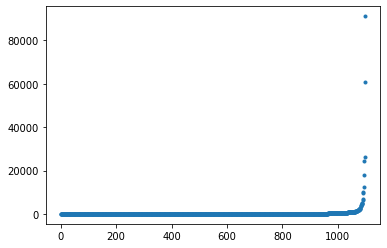

In [157]:
plot(list(post_df.post_score.sort_values()), '.');

## Some more descriptive analysis

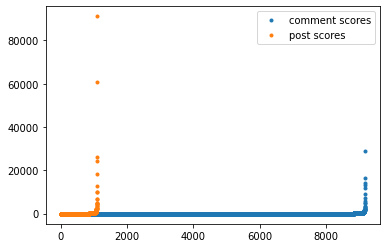

In [160]:
figure()
plot(list(comment_df.comment_score.sort_values()), '.', label="comment scores");
plot(list(post_df.post_score.sort_values()), '.', label="post scores");

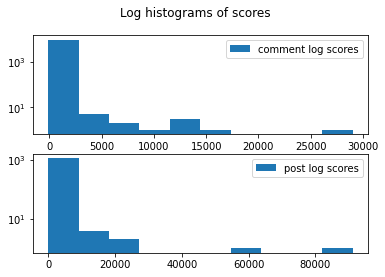

In [167]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Log histograms of scores')
ax1.hist(comment_df.comment_score, log=True, label="comment log scores");
ax1.legend();
ax2.hist(post_df.post_score, log=True, label="post log scores");
ax2.legend();

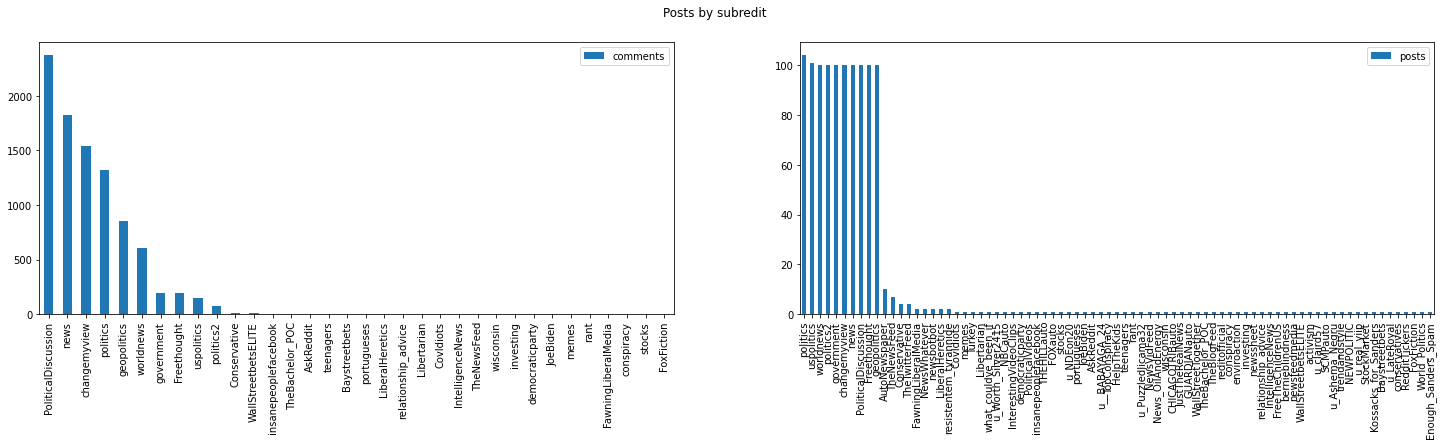

In [179]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
fig.suptitle('Posts by subredit')
comment_df.subreddit.value_counts().plot(ax=ax1, kind='bar',label="comments")
post_df.subreddit.value_counts().plot(ax=ax2, kind='bar',label="posts")
ax1.legend();
ax2.legend();